# 空洞卷积实验

## 0 数据加载

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import os
from tqdm.auto import tqdm
import time
from PIL import Image
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(114514)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(114514)

DATA_ROOT = (
    "D:/files/works/DeepLearning/experiment3/data/car-classificationproject-vision"
)


class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f
            for f in os.listdir(root_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        try:
            self.image_files.sort(
                key=lambda x: int(x.split(".")[0].replace("image", ""))
            )
        except ValueError:
            self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name


def setup_data_loaders(
    data_root: str,
    image_size: int = 227,
    batch_size: int = 45,
    split_ratio: float = 0.8,
    num_workers: int = 6,
    prefetch_factor: int = 4,
) -> tuple[DataLoader, DataLoader, DataLoader, int]:
    TRAIN_DIR = os.path.join(data_root, "Train/Train")
    TEST_DIR = os.path.join(data_root, "Test/Test/Test1")
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    train_transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ]
    )
    eval_transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ]
    )
    full_train_dataset = datasets.ImageFolder(
        root=TRAIN_DIR, transform=train_transforms
    )
    full_eval_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=eval_transforms)
    num_classes = len(full_train_dataset.classes)
    total_size = len(full_train_dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size
    random.seed(42)
    indices = list(range(total_size))
    random.shuffle(indices)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_eval_dataset, val_indices)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True,
    )
    test_dataset = CustomTestDataset(root_dir=TEST_DIR, transform=eval_transforms)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True,
    )
    print(f"✓ 检测到的类别数量: {num_classes}")
    print(f"✓ 训练集大小: {len(train_dataset)} (使用数据增强)")
    print(f"✓ 验证集大小: {len(val_dataset)} (不使用数据增强)")
    print(f"✓ 测试集大小: {len(test_dataset)}")
    print(f"✓ 数据加载完成，Batch Size: {batch_size}")
    return train_loader, val_loader, test_loader, num_classes

## 1  使用torch.nn实现空洞卷积，要求dilation满足HDC条件（如1,2,5）且要堆叠多层并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

In [ ]:
class Model(nn.Module):
    def __init__(
        self,
        chns_in: int,
        chns_base: int,
        feats_base: int,
        nums_classes: int,
        dropout_rate: float,
        ker_size: int,
        dilation: list[int],
        # padding: int = 0,  # useless：padding由dilation和kernel_size计算得出，此处不再传入
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.chns_in = chns_in
        self.chns_base = chns_base
        self.feats_base = feats_base
        self.nums_classes = nums_classes
        self.dropout_rate = dropout_rate
        self.ker_size = ker_size
        self.dilation = dilation
        self.padding = [d * (ker_size - 1) // 2 for d in dilation]
        self.stride = stride

        assert (
            len(dilation) == 4
        ), "dilation length must match number of conv layers (4)"

        self.conv = nn.Sequential(
            # cov1
            nn.Conv2d(
                chns_in,
                chns_base * 1,
                kernel_size=ker_size,
                padding=self.padding[0],
                stride=self.stride,
                dilation=self.dilation[0],
            ),
            nn.BatchNorm2d(chns_base * 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # cov2
            nn.Conv2d(
                chns_base * 1,
                chns_base * 2,
                kernel_size=ker_size,
                padding=self.padding[1],
                stride=self.stride,
                dilation=self.dilation[1],
            ),
            nn.BatchNorm2d(chns_base * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # conv3
            nn.Conv2d(
                chns_base * 2,
                chns_base * 4,
                kernel_size=ker_size,
                padding=self.padding[2],
                stride=self.stride,
                dilation=self.dilation[2],
            ),
            nn.BatchNorm2d(chns_base * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # conv4
            nn.Conv2d(
                chns_base * 4,
                chns_base * 8,
                kernel_size=ker_size,
                padding=self.padding[3],
                stride=self.stride,
                dilation=self.dilation[3],
            ),
            nn.BatchNorm2d(chns_base * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Sequential(
            # fc1
            nn.Linear(self.chns_base * 8, self.feats_base),
            # nn.BatchNorm1d(self.feats_base),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_rate),
            # # fc2
            # nn.Linear(self.feats_base, self.feats_base),
            # nn.BatchNorm1d(self.feats_base),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=self.dropout_rate),
            # fc3
            nn.Linear(self.feats_base, self.nums_classes),
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.pool(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)
        return X

In [3]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

    def __call__(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.calc(y_pred, y_true)

In [4]:
class Optimizer:
    def __init__(
        self, model: Model, lr: float = 0.01, weight_decay: float = 0.01
    ) -> None:
        self.optimizer = optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [5]:
def evaluation(model: Model, loss: Loss, data_loader: DataLoader, device: torch.device):
    model.eval()
    with torch.no_grad():
        total_nums = 0
        data_loss_value, data_acc_value = 0, 0
        tqdm_batch = tqdm(
            data_loader,
            desc="Eval",
            leave=False,
            position=1,
            mininterval=1,
            maxinterval=10,
            smoothing=0.1,
        )
        for features, labels in tqdm_batch:
            features, labels = features.to(device), labels.to(device)
            predict = model(features)
            loss_value = loss(predict, labels)

            total_nums += len(labels)
            data_loss_value += loss_value.item() * len(labels)
            data_acc_value += (predict.argmax(dim=1) == labels).sum().item()
            tqdm_batch.set_postfix_str(f"Current Batch Loss={loss_value.item():.4f}")
        data_loss_value /= total_nums
        data_acc_value /= total_nums
    return data_loss_value, data_acc_value

In [6]:
def train(
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nnum_epoches: int,
    device: torch.device,
    accumulation_steps: int,
):
    print(f"batch积累倍率:{accumulation_steps}")
    train_loss_list, train_acc_list = [], []
    valid_loss_list, valid_acc_list = [], []
    tqdm_epoch = tqdm(
        range(nnum_epoches),
        desc="Epochs",
        leave=True,
        position=0,
        mininterval=1,
        maxinterval=10,
        smoothing=0.1,
    )
    for epoch in tqdm_epoch:
        model.train()
        total_nums = 0
        train_loss, train_acc = 0.0, 0.0
        # 在循环开始前清零
        optimizer.zero_grad()
        tqdm_batch = tqdm(
            train_loader,
            desc=f"Train",
            leave=False,
            position=1,
            mininterval=1,
            maxinterval=10,
            smoothing=0.1,
        )
        for i, (images, labels) in enumerate(tqdm_batch):
            images, labels = images.to(device), labels.to(device)
            # 前向计算
            predict = model(images)
            raw_loss = loss(predict, labels)  # 保存原始 loss 用于统计
            # 1. 梯度缩放与反向传播
            loss_accumulated = raw_loss / accumulation_steps
            loss_accumulated.backward()
            # 2. 达到步数更新梯度
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            # 3. 统计数据使用原始 loss (raw_loss)
            total_nums += len(labels)
            train_loss += raw_loss.item() * len(labels)  # 这里用 raw_loss 保证统计准确
            train_acc += (predict.argmax(dim=1) == labels).sum().item()
            # 更新当前batch信息
            tqdm_batch.set_postfix_str(f"Current Batch Loss={raw_loss.item():.4f}")
        # 4. 处理 Epoch 末尾未达步数的残余梯度
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        # 计算平均值并输出返回
        train_loss /= total_nums
        train_acc /= total_nums
        valid_loss, valid_acc = evaluation(model, loss, valid_loader, device)
        tqdm_epoch.set_postfix_str(
            f"epoch{epoch+1} Info:\
            TrainLoss={train_loss:.4f} ValidLoss={valid_loss:.4f} \
            TrainAcc={train_acc:.4f} ValidAcc={valid_acc:.4f}",
        )
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [7]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = [], [], [], []
time_start, time_end = 0, 0
if __name__ == "__main__":
    train_loader, val_loader, test_loader, num_classes = setup_data_loaders(
        data_root=DATA_ROOT,
        image_size=224,
        batch_size=8,
        split_ratio=0.8,
        num_workers=6,
        prefetch_factor=8,
    )
    model = Model(
        chns_in=3,
        chns_base=64,
        feats_base=1024,
        dropout_rate=0.5,
        ker_size=3,
        nums_classes=num_classes,
        dilation=[1, 2, 5, 7],
        stride=1,
    ).to(device)
    loss = Loss()
    optimizer = Optimizer(model=model, lr=1e-3, weight_decay=1e-4)
    time_start = time.perf_counter()
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(
        model=model,
        loss=loss,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=val_loader,
        nnum_epoches=64,
        device=device,
        accumulation_steps=4,
    )
    time_end = time.perf_counter()
    print(f"Time elapsed: {time_end - time_start:.2f}s")

✓ 检测到的类别数量: 45
✓ 训练集大小: 3240 (使用数据增强)
✓ 验证集大小: 810 (不使用数据增强)
✓ 测试集大小: 450
✓ 数据加载完成,Batch Size: 8
batch积累倍率:4


Epochs:   0%|          | 0/64 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:22<?, ?it/s]

Eval:   0%|          | 0/102 [00:22<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Train:   0%|          | 0/405 [00:00<?, ?it/s]

Eval:   0%|          | 0/102 [00:00<?, ?it/s]

Time elapsed: 1149.21s


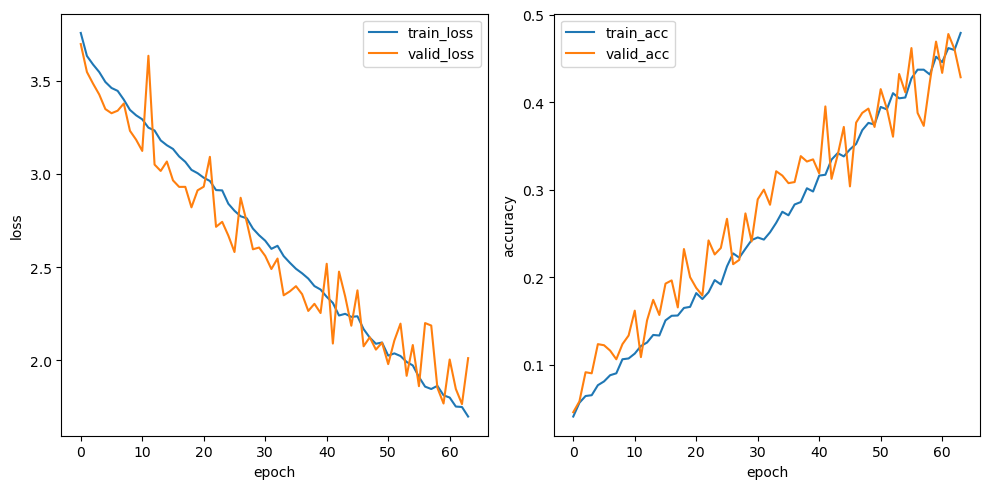

In [8]:
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_list, label="train_loss")
axes[0].plot(valid_loss_list, label="valid_loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[1].plot(train_acc_list, label="train_acc")
axes[1].plot(valid_acc_list, label="valid_acc")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()

## 2 将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析

In [9]:
# 不再另写代码，直接在实验报告中，根据3-1.2的结果与3-2.1的结果对比，进行分析。

## 3 不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）